In [ ]:
# Import all the necessary libraries
import yfinance as yf
import torch
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt

In [ ]:
# Loading the data
ticker = 'AAPL'
start_date = '2015-01-01'
end_date = '2024-12-31'

data = yf.download(ticker, start=start_date, end=end_date) # Downloads apple stock data from yfinance
close_prices = data['Close'].values.reshape(-1, 1)

/tmp/ipython-input-2229240782.py:5: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed


In [ ]:
scaler = MinMaxScaler(feature_range=(0, 1)) # # Scale data values to be between 0 and 1, helps optimize learning
scaled_prices = scaler.fit_transform(close_prices)

lookback = 60
X, y = [], []

# Grabs 60 consecutive days (X), then grabs the 61st day price (y), then slides the window one day and repeats this
for i in range(lookback, len(scaled_prices)):
  X.append(scaled_prices[i-lookback:i, 0])
  y.append(scaled_prices[i, 0])

X, y = np.array(X), np.array(y)
X = np.reshape(X, (X.shape[0], X.shape[1], 1))

# Split data chronologically
split_ratio = 0.8
split_index = int(len(X) * split_ratio)

# Train, test split --> We train on the first 80% of data and have to predict the last 20%
X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

# Convert to PyTorch tensors (special array that works well with GPUs)
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32).reshape(-1, 1)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32).reshape(-1, 1)

train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=False)

In [ ]:
'''
Defines the LSTM (Long Short Term Memory) Model
LSTM is a special type of neural network that has a form of memory.
As it processes the 60 day sequence, it can identify important patterns it saw on days 5, 20, and 50, for example, and use those to make a better prediction.
'''
class LSTMModel(nn.Module):
  def __init__(self, input_size=1, hidden_layer_size=50, num_layers=2, output_size=1):
    super().__init__()
    self.hidden_layer_size = hidden_layer_size
    # LSTM layer to process the sequence
    self.lstm = nn.LSTM(input_size, hidden_layer_size, num_layers, batch_first=True, dropout=0.2)
    # Linear layer to make final prediction
    self.linear = nn.Linear(hidden_layer_size, output_size)

  # Defines how data flows through the model --> First 60 day sequence goes into LSTM, then take last output and make a prediction
  def forward(self, input_seq):
    lstm_out, _ = self.lstm(input_seq)
    predictions = self.linear(lstm_out[:, -1])
    return predictions

In [ ]:
model = LSTMModel() # Instance of the model defined above
loss_function = nn.MSELoss() # Use Mean Squared Error to calculate error
optimizer = torch.optim.Adam(model.parameters(), lr=0.001) # Adjust the weights of the model to be less wrong next time

epochs = 25 # How many times we go through the training data
for i in range(epochs):
  for seq, labels in train_loader:
    optimizer.zero_grad() # Clear any old adjustments
    y_pred = model(seq) # Make a prediction based on the input sequence
    single_loss = loss_function(y_pred, labels) # See how wrong the prediction was
    single_loss.backward() # Figures out how much each weight contributed to the error
    optimizer.step() # Uses information from previous step to adjust weights to be less wrong

  if(i%5 == 0):
    print(f'epoch: {i:2} loss: {single_loss.item():10.8f}')

epoch:  0 loss: 0.00540003
epoch:  5 loss: 0.00062229
epoch: 10 loss: 0.00097832
epoch: 15 loss: 0.00606879
epoch: 20 loss: 0.00610081


In [ ]:
model.eval() # Switches model to evaluation behavior rather than training behavior

# Tells PyTorch to ignore the backpropagation step --> makes process faster (we are predicting not learning)
with torch.no_grad():
  test_predictions_scaled = model(X_test)

# Scale back to dollar amounts so we can make sense of things
predictions = scaler.inverse_transform(test_predictions_scaled.numpy())
y_test_actual = scaler.inverse_transform(y_test.numpy())

# Take the square root of the MSE to find the average amount our model was off
rmse = np.sqrt(mean_squared_error(y_test_actual, predictions))
print(f"Root Mean Squared Error: {rmse}")

train_data = data['Close'][:split_index+lookback]
validation_data = data[['Close']][split_index+lookback:]
validation_data['Predictions'] = predictions


Root Mean Squared Error: 27.11855369649797


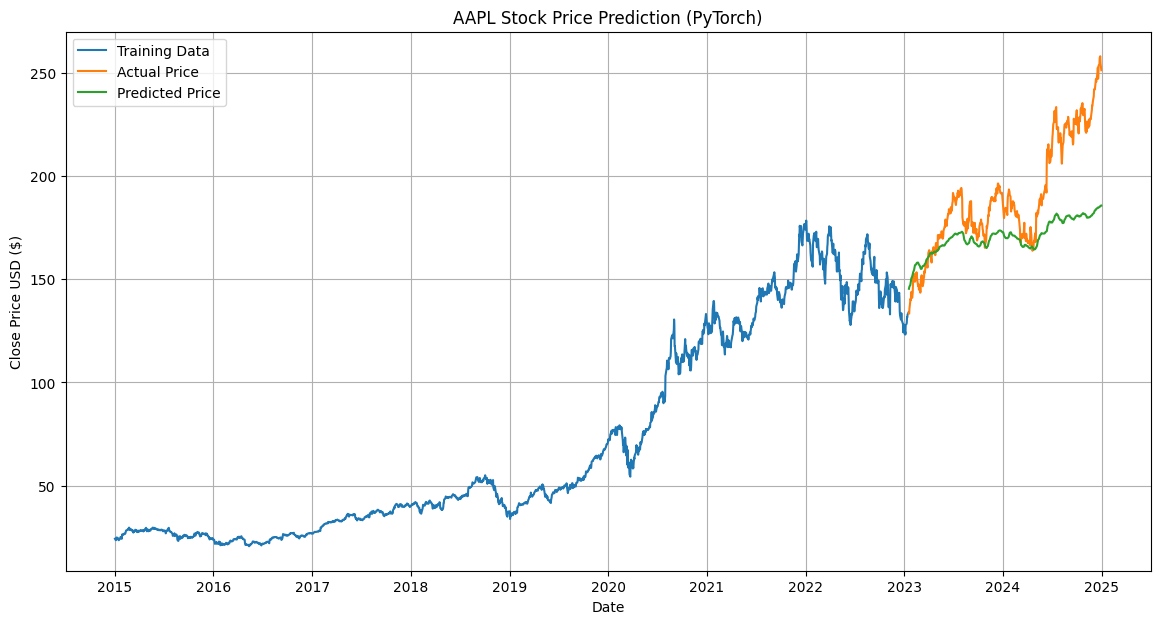

In [ ]:
# Plot the results
plt.figure(figsize=(14, 7))
plt.title(f'{ticker} Stock Price Prediction (PyTorch)')
plt.xlabel('Date')
plt.ylabel('Close Price USD ($)')
plt.plot(train_data, label='Training Data')
plt.plot(validation_data[['Close']], label='Actual Price')
plt.plot(validation_data[['Predictions']], label='Predicted Price')
plt.legend()
plt.grid(True)
plt.show()